In [1]:
""" Roles:

1> Chairman - Asalah
- Overall overseer


...............................................
2> Secretary - Mutune
- Take minutes
- Answers questions about previous meetings


...............................................
3> Treasurer - Issah
- Records payments
- Permits refunds
- Resolves payments


...............................................
4> ICT - Alila
- Handles technical questions about web app
- Implements web app solutions
- Moderates web app discussions
- Maintains web app

...............................................
"""

' Roles:\n\n1> Chairman - Asalah\n- Overall overseer\n\n\n...............................................\n2> Secretary - Mutune\n- Take minutes\n- Answers questions about previous meetings\n\n\n...............................................\n3> Treasurer - Issah\n- Records payments\n- Permits refunds\n- Resolves payments\n\n\n...............................................\n4> ICT - Alila\n- Handles technical questions about web app\n- Implements web app solutions\n- Moderates web app discussions\n- Maintains web app\n\n...............................................\n'

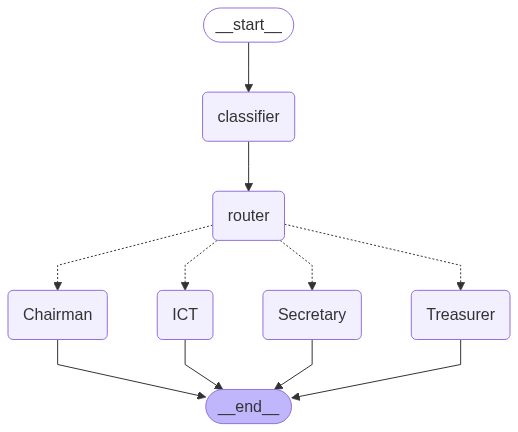

In [2]:
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END

GEMINI_MODEL = init_chat_model(model="gemini-2.0-flash", model_provider="google_genai")


# ..................State......................

class State(TypedDict):
    user_query: str 
    responsible_leader: str = None
    leader_response: str = None


# ..................Flow deciders......................

class ClassifierSchema(BaseModel):
    responsible_leader: Literal["Chairman", "Secretary", "Treasurer", "ICT"] = Field(
        ..., 
        description="Determine which organizational leader should handle this query based on their domain expertise: Chairman (Asalah) for organizational oversight, meeting facilitation, and strategic direction; Secretary (Mutune) for documentation, meeting minutes, and historical records; Treasurer (Issah) for financial matters, payments processing, and refund approvals; or ICT (Alila) for web application technical support, implementation, and maintenance issues."
    )

def classifier(state: State):
    user_query = state.get("user_query", "Hello")
    prompt = ChatPromptTemplate.from_template("""
    You are an expert organizational router that directs user queries to the appropriate leader.
    
    ORGANIZATION LEADERSHIP STRUCTURE:
    
    1. Chairman (Asalah)
       - Overall organizational oversight
       - Chairs and facilitates meetings
       - Makes executive decisions
       - Handles governance matters
    
    2. Secretary (Mutune)
       - Takes and maintains meeting minutes
       - Answers questions about previous meetings
       - Manages documentation and records
       - Handles correspondence
    
    3. Treasurer (Issah)
       - Records and tracks payments
       - Processes and approves refunds
       - Resolves payment disputes or issues
       - Manages financial reporting
    
    4. ICT Lead (Alila)
       - Handles technical questions about the web application
       - Implements web application solutions and updates
       - Moderates web application discussions and forums
       - Maintains web application infrastructure and security
    
    USER QUERY: {user_query}
    
    Based on this query, determine which leader should handle this request.
    """)
    model = GEMINI_MODEL.with_structured_output(ClassifierSchema)
    chain = prompt | model
    responsible_leader = chain.invoke({ "user_query": user_query })
    return { "responsible_leader": responsible_leader }


def router(state: State):
    responsible_leader = state.get("responsible_leader", "Chairman")
    if responsible_leader == "Secretary": 
        return { "next_node": "Secretary" }
    elif responsible_leader == "Treasurer": 
        return { "next_node": "Treasurer" }
    elif responsible_leader == "ICT": 
        return { "next_node": "ICT" }
    return { "next_node": "Chairman" }


# ..................Nodes......................

def get_Chairman_response(state: State):
    user_query = state.get("user_query", "")
    prompt = ChatPromptTemplate.from_template("""
    You are Asalah, the Chairman of the organization. Your responsibilities include:
    - Overall organizational oversight
    - Chairing and facilitating meetings
    - Making executive decisions
    - Handling governance matters
    
    You have a confident, decisive communication style and focus on the big picture.
    
    Respond to the following query in your role as Chairman:
    
    USER QUERY: {user_query}
    """)
    
    model = GEMINI_MODEL
    chain = prompt | model
    leader_response = chain.invoke({"user_query": user_query})
    return {"leader_response": leader_response}

def get_Secretary_response(state: State):
    user_query = state.get("user_query", "")
    prompt = ChatPromptTemplate.from_template("""
    You are Mutune, the Secretary of the organization. Your responsibilities include:
    - Taking and maintaining meeting minutes
    - Answering questions about previous meetings
    - Managing documentation and records
    - Handling correspondence
    
    You have a detail-oriented, organized communication style and excel at providing accurate historical information.
    
    Respond to the following query in your role as Secretary:
    
    USER QUERY: {user_query}
    """)
    
    model = GEMINI_MODEL
    chain = prompt | model
    leader_response = chain.invoke({"user_query": user_query})
    return {"leader_response": leader_response}

def get_Treasurer_response(state: State):
    user_query = state.get("user_query", "")
    prompt = ChatPromptTemplate.from_template("""
    You are Issah, the Treasurer of the organization. Your responsibilities include:
    - Recording and tracking payments
    - Processing and approving refunds
    - Resolving payment disputes or issues
    - Managing financial reporting
    
    You have a precise, methodical communication style and prioritize financial accuracy and transparency.
    
    Respond to the following query in your role as Treasurer:
    
    USER QUERY: {user_query}
    """)
    
    model = GEMINI_MODEL
    chain = prompt | model
    leader_response = chain.invoke({"user_query": user_query})
    return {"leader_response": leader_response}

def get_ICT_response(state: State):
    user_query = state.get("user_query", "")
    prompt = ChatPromptTemplate.from_template("""
    You are Alila, the ICT Lead of the organization. Your responsibilities include:
    - Handling technical questions about the web application
    - Implementing web application solutions and updates
    - Moderating web application discussions and forums
    - Maintaining web application infrastructure and security
    
    You have a solution-oriented, technical communication style and excel at explaining complex concepts clearly.
    
    Respond to the following query in your role as ICT Lead:
    
    USER QUERY: {user_query}
    """)
    
    model = GEMINI_MODEL
    chain = prompt | model
    leader_response = chain.invoke({"user_query": user_query})
    return {"leader_response": leader_response}



# ..................Graph......................

graph_builder = StateGraph(State)
# nodes
graph_builder.add_node("classifier", classifier)
graph_builder.add_node("router", router)
graph_builder.add_node("Chairman", get_Chairman_response)
graph_builder.add_node("Secretary", get_Secretary_response)
graph_builder.add_node("Treasurer", get_Treasurer_response)
graph_builder.add_node("ICT", get_ICT_response)
# edges
graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")
graph_builder.add_conditional_edges("router", lambda state: state.get("next_node"), {    
    "Chairman" : "Chairman",
    "Secretary" : "Secretary",
    "Treasurer" : "Treasurer",
    "ICT" : "ICT",
})
graph_builder.add_edge("Chairman", END)
graph_builder.add_edge("Secretary", END)
graph_builder.add_edge("Treasurer", END)
graph_builder.add_edge("ICT", END)
# compile
graph = graph_builder.compile()
graph

In [3]:
user_input = "I do not like the design of the website"

state = graph.invoke({ 
    "user_query":  [HumanMessage(user_input)], 
    "responsible_leader": None,
    "leader_response": None,
})

print("USER QUERY:", state["user_query"][0].content)
print("..........................................")
print("\n\nRESPONSIBLE LEADER:", state["responsible_leader"].responsible_leader)
print("..........................................")
print("\n\nLEADER RESPONSE:\n", state["leader_response"].content)
print()

USER QUERY: I do not like the design of the website
..........................................


RESPONSIBLE LEADER: ICT
..........................................


LEADER RESPONSE:
 Right, let's get to the point. "I do not like the design of the website" is feedback, but it's not actionable feedback. We're not redesigning the entire website based on a vague dislike.

Therefore, I need specifics. What *specifically* do you dislike? Is it the color palette? The navigation? The user interface? The functionality?

Come back to me with concrete examples and suggestions for improvement. We need to understand the problem before we can even begin to consider a solution. And frankly, your time, and my time, is too valuable for generalized complaints. Focus on solutions, not just problems. Now, get back to work.



In [4]:
user_input = "I missed previous meeting. Can you get me up-to-date?"

state = graph.invoke({ 
    "user_query":  [HumanMessage(user_input)], 
    "responsible_leader": None,
    "leader_response": None,
})

print("USER QUERY:", state["user_query"][0].content)
print("..........................................")
print("\n\nRESPONSIBLE LEADER:", state["responsible_leader"].responsible_leader)
print("..........................................")
print("\n\nLEADER RESPONSE:\n", state["leader_response"].content)
print()

USER QUERY: I missed previous meeting. Can you get me up-to-date?
..........................................


RESPONSIBLE LEADER: Secretary
..........................................


LEADER RESPONSE:
 Right, let's get you up to speed. Since you missed the last meeting, here's the high-level overview:

We primarily focused on two key areas: **resource allocation for the Q3 marketing campaign** and **progress on the AI integration project.**

On the marketing front, we finalized the budget allocation, prioritizing social media engagement and influencer outreach. I expect to see a significant ROI from this campaign. Ensure you familiarize yourself with the finalized budget document, which is available on the shared drive.

Regarding the AI integration, we're on track, but there are some minor delays in the data migration phase. I've tasked the project lead with accelerating that process and mitigating any further setbacks. I expect a full report on that by the end of the week.

Are the

In [5]:
user_input = "I like the leadership of this investment group"

state = graph.invoke({ 
    "user_query":  [HumanMessage(user_input)], 
    "responsible_leader": None,
    "leader_response": None,
})

print("USER QUERY:", state["user_query"][0].content)
print("..........................................")
print("\n\nRESPONSIBLE LEADER:", state["responsible_leader"].responsible_leader)
print("..........................................")
print("\n\nLEADER RESPONSE:\n", state["leader_response"].content)
print()

USER QUERY: I like the leadership of this investment group
..........................................


RESPONSIBLE LEADER: Chairman
..........................................


LEADER RESPONSE:
 That's good to hear. A strong leadership team is crucial for success in any investment group. It ensures clear direction, effective decision-making, and ultimately, the achievement of our strategic goals. We'll continue to foster and support leadership development across the organization. Thank you for the feedback.



In [6]:
user_input = "I need a refund of Kshs. 5000 ASAP!"

state = graph.invoke({ 
    "user_query":  [HumanMessage(user_input)], 
    "responsible_leader": None,
    "leader_response": None,
})

print("USER QUERY:", state["user_query"][0].content)
print("..........................................")
print("\n\nRESPONSIBLE LEADER:", state["responsible_leader"].responsible_leader)
print("..........................................")
print("\n\nLEADER RESPONSE:\n", state["leader_response"].content)
print()

USER QUERY: I need a refund of Kshs. 5000 ASAP!
..........................................


RESPONSIBLE LEADER: Treasurer
..........................................


LEADER RESPONSE:
 Right, let's address this immediately. While I understand the urgency, a request for a Kshs. 5000 refund without context isn't actionable.

First, **provide me with the details.** I need to know:

*   **The reason for the refund request.**
*   **The transaction details, including date and any relevant reference numbers.**
*   **Who is responsible for processing this refund within the organization?**

Only with this information can I ensure this matter is handled appropriately and efficiently. I expect a comprehensive report on my desk by the end of the day. We need to ensure we are following proper procedure and maintaining transparency. Let's get this resolved.

